# Early-Stage Diabetes Risk Prediction

**Project objective:** Build a model to predict early-stage diabetes using simple clinical features. This notebook includes step-by-step teaching notes.


## Step 0 — Setup

Run the next cell to import required packages. If a package is missing in Colab, uncomment the pip install line.

In [1]:
# !pip install --quiet seaborn scikit-learn
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.inspection import permutation_importance
sns.set(style='whitegrid')
%matplotlib inline
print('Packages loaded')

Packages loaded


## Step 1 — Load data

Upload the file`diabetes_data.csv` first to the content folder.

In [2]:
DATA_PATH = 'diabetes_data.csv'
df = pd.read_csv(DATA_PATH)
print('Rows,Cols:', df.shape)
df.head()

Rows,Cols: (520, 17)


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


## Step 2 — Inspect & Clean

Standardize column names and inspect unique values.

In [3]:
# Standardize column names
cols = [c.strip().lower().replace(' ', '_').replace('-', '_') for c in df.columns]
df.columns = cols
print('\nMissing values:')
print(df.isnull().sum())


Missing values:
age                   0
gender                0
polyuria              0
polydipsia            0
sudden_weight_loss    0
weakness              0
polyphagia            0
genital_thrush        0
visual_blurring       0
itching               0
irritability          0
delayed_healing       0
partial_paresis       0
muscle_stiffness      0
alopecia              0
obesity               0
class                 0
dtype: int64


## Step 3 — Encode categorical variables

Map Yes/No to 1/0, Male/Female to 1/0, and class to 1/0. We crated a copf dataframe (df_clean) after making the changes.

In [4]:
# Mappings
yes_no_map = {'yes':1, 'no':0, 'Yes':1, 'No':0, 'YES':1, 'NO':0}
gender_map = {'male':1, 'female':0, 'Male':1, 'Female':0, 'M':1, 'F':0}
class_map = {'positive':1, 'negative':0, 'Positive':1, 'Negative':0}

df_clean = df.copy()
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        # strip spaces
        df_clean[col] = df_clean[col].str.strip()
        if set(df_clean[col].dropna().unique()).intersection({'Yes','No','yes','no','YES','NO'}):
            df_clean[col] = df_clean[col].map(yes_no_map)
        elif set(df_clean[col].dropna().unique()).intersection({'Male','Female','male','female','M','F'}):
            df_clean[col] = df_clean[col].map(gender_map)
        elif col == 'class' or 'class' in col:
            df_clean[col] = df_clean[col].map(class_map)

print('Types after mapping:')
print(df_clean.dtypes)

Types after mapping:
age                   int64
gender                int64
polyuria              int64
polydipsia            int64
sudden_weight_loss    int64
weakness              int64
polyphagia            int64
genital_thrush        int64
visual_blurring       int64
itching               int64
irritability          int64
delayed_healing       int64
partial_paresis       int64
muscle_stiffness      int64
alopecia              int64
obesity               int64
class                 int64
dtype: object


## Step 4 — Handle missing values

Convert columns to numeric where possible and impute simple missing values.

In [5]:
for col in df_clean.columns:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

print('Missing before impute:\n', df_clean.isnull().sum())

for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        if df_clean[col].dropna().isin([0,1]).all():
            df_clean[col] = df_clean[col].fillna(0)
        else:
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())

print('Missing after impute:\n', df_clean.isnull().sum())

Missing before impute:
 age                   0
gender                0
polyuria              0
polydipsia            0
sudden_weight_loss    0
weakness              0
polyphagia            0
genital_thrush        0
visual_blurring       0
itching               0
irritability          0
delayed_healing       0
partial_paresis       0
muscle_stiffness      0
alopecia              0
obesity               0
class                 0
dtype: int64
Missing after impute:
 age                   0
gender                0
polyuria              0
polydipsia            0
sudden_weight_loss    0
weakness              0
polyphagia            0
genital_thrush        0
visual_blurring       0
itching               0
irritability          0
delayed_healing       0
partial_paresis       0
muscle_stiffness      0
alopecia              0
obesity               0
class                 0
dtype: int64


## Step 5 — EDA

Plot class balance, age distribution, and symptom prevalence heatmap (where higher mean or dark heat map means that variable is high predictor for DM).

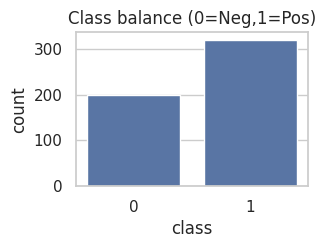

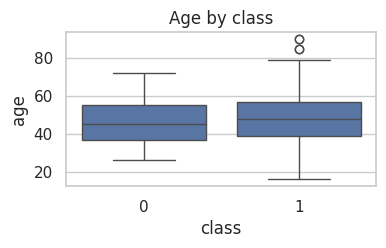

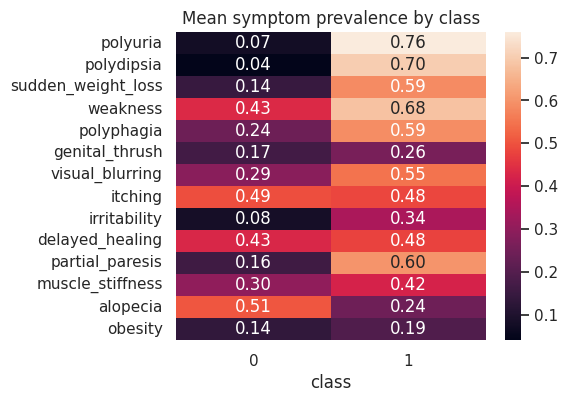

In [6]:
plt.figure(figsize=(3,2))
sns.countplot(x=df_clean['class'])
plt.title('Class balance (0=Neg,1=Pos)')
plt.show()

plt.figure(figsize=(4,2))
sns.boxplot(x=df_clean['class'], y=df_clean['age'])
plt.title('Age by class')
plt.show()

symptom_cols = [c for c in df_clean.columns if c not in ['age','class','gender']]
symptom_means = df_clean.groupby('class')[symptom_cols].mean().T
plt.figure(figsize=(5,4))
sns.heatmap(symptom_means, annot=True, fmt='.2f')
plt.title('Mean symptom prevalence by class')
plt.show()

## Step 6 — Prepare data and split

Scale age and do a stratified train-test split.

X: all independent variables (predictors) — symptoms and demographics.

y: the dependent variable (target) — diabetes class (0 = Negative, 1 = Positive).

Dropping class from X ensures you don’t accidentally “leak” the answer to the model.


- Train–test split

Purpose: separate data into:

80% for training (X_train, y_train)

20% for testing (X_test, y_test)

stratify=y ensures both sets maintain the same proportion of positive and negative cases — crucial for balanced evaluation.

random_state=42 fixes the random seed so results are reproducible.

This prevents overfitting and allows you to test your model on unseen data.


Scale (standardize) the numeric feature(s)

Why scaling matters:
Some algorithms (e.g., logistic regression, SVM, KNN) perform better when numerical features are standardized — i.e., centered at 0 and scaled by standard deviation.

StandardScaler():
Transforms age so that it has:
Mean = 0
Standard deviation = 1

Formula:

𝑧=𝑥−𝜇𝜎z=σx−μ
	​
Note: Only age is scaled because all other features are binary (0 or 1).

Scaling those would distort their meaning.

Fit on train, transform on both:

*   fit_transform() learns the mean and SD only from the training data (to avoid information leakage).
*   transform() applies the same scaling parameters to the test set.


Output shape
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Confirms the dataset sizes, typically something like:

*   Train shape: (416, 16) Test shape: (104, 16)

This is expected since we split 520 samples into 80/20.







In [7]:
X = df_clean.drop('class', axis=1)
y = df_clean['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
if 'age' in X.columns:
    X_train = X_train.copy()
    X_test = X_test.copy()
    X_train['age'] = scaler.fit_transform(X_train[['age']])
    X_test['age'] = scaler.transform(X_test[['age']])

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (416, 16) Test shape: (104, 16)


## Step 7 — Train models

Fit Logistic Regression and Random Forest, then evaluate.

In [8]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:,1]

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

def evaluate(y_true, y_pred, y_proba):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_proba)
    }

lr_metrics = evaluate(y_test, y_pred_lr, y_proba_lr)
rf_metrics = evaluate(y_test, y_pred_rf, y_proba_rf)
pd.DataFrame([lr_metrics, rf_metrics], index=['LogisticRegression','RandomForest'])

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.942308,0.983333,0.921875,0.951613,0.990625
RandomForest,0.980769,0.984375,0.984375,0.984375,0.998828


## Step 8 — Confusion matrices & ROC

Visualize confusion matrices and ROC curves for both models.

  Confusion Matrix shows true vs. predicted classes:

True Positive (TP): correctly identified diabetics

False Positive (FP): incorrectly predicted diabetics

True Negative (TN): correctly identified non-diabetics

False Negative (FN): missed diabetics

  ROC Curve visualizes the trade-off between sensitivity and specificity.

The closer the curve is to the top-left corner, the better.

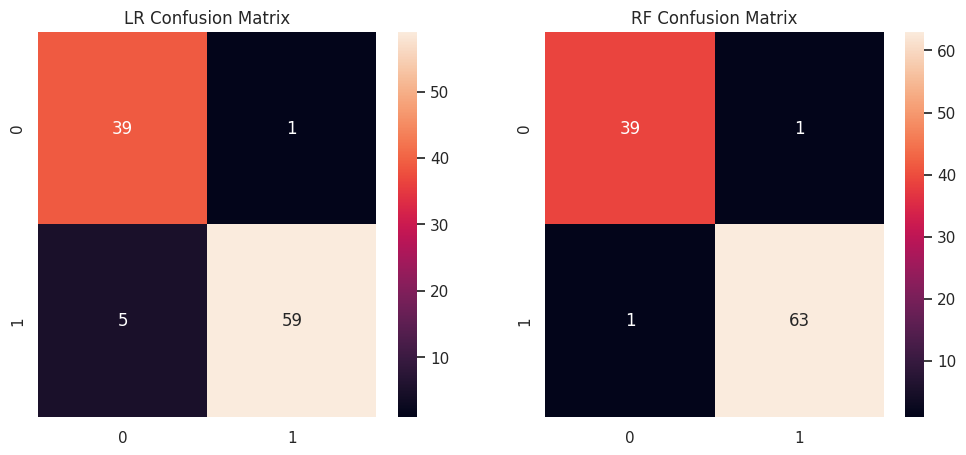

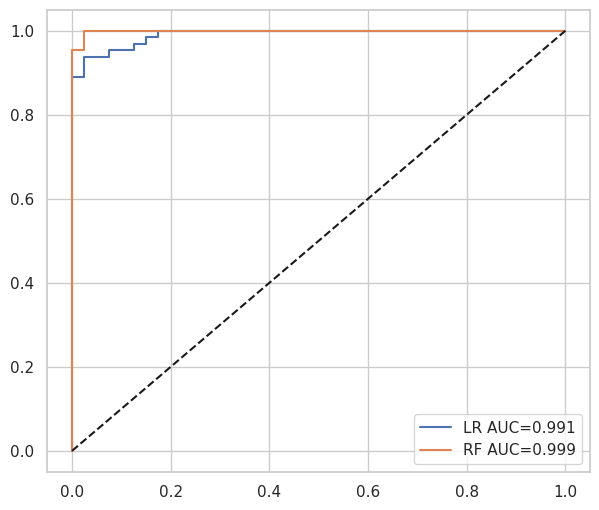

In [9]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', ax=axes[0])
axes[0].set_title('LR Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', ax=axes[1])
axes[1].set_title('RF Confusion Matrix')
plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(7,6))
plt.plot(fpr_lr, tpr_lr, label=f'LR AUC={lr_metrics["roc_auc"]:.3f}')
plt.plot(fpr_rf, tpr_rf, label=f'RF AUC={rf_metrics["roc_auc"]:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.show()

## Step 9 — Interpretability

Show Random Forest importances and permutation importance.

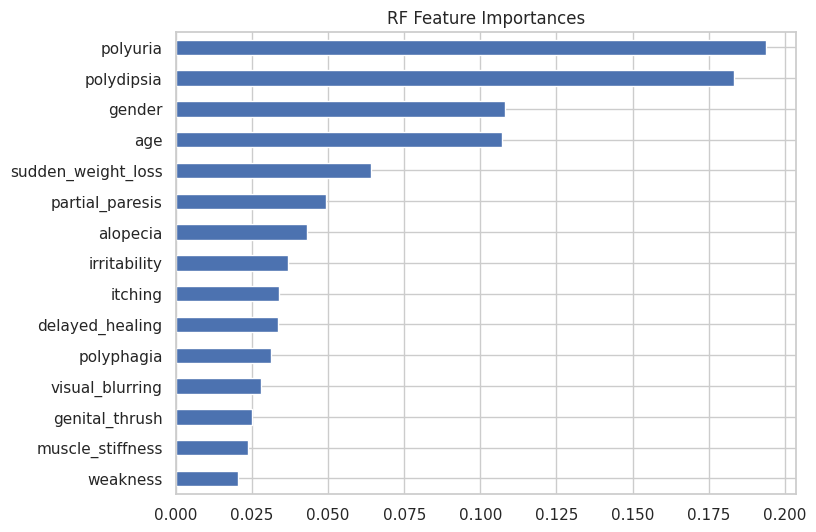

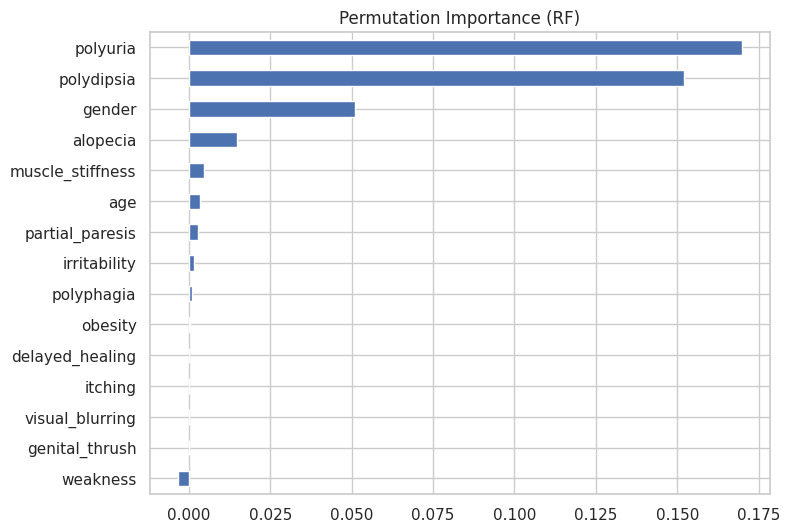

In [10]:
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values()
plt.figure(figsize=(8,6))
imp.tail(15).plot(kind='barh')
plt.title('RF Feature Importances')
plt.show()

perm = permutation_importance(rf, X_test, y_test, n_repeats=20, random_state=42)
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values()
plt.figure(figsize=(8,6))
perm_imp.tail(15).plot(kind='barh')
plt.title('Permutation Importance (RF)')
plt.show()

## Step 10 — Save outputs & next steps

Save cleaned data and model metrics. Next: hyperparameter tuning, CV, SHAP, and a Power BI dashboard showing predicted risk by patient.

In [11]:
os.makedirs('outputs', exist_ok=True)
df_clean.to_csv('outputs/data_clean.csv', index=False)
pd.DataFrame([lr_metrics, rf_metrics], index=['LogisticRegression','RandomForest']).to_csv('outputs/model_metrics.csv')
print('Saved outputs to outputs/')

Saved outputs to outputs/


# Step 11 — Loading Trained Model and entering new patient to see the Specific Diabetes risk status of that patient

In [15]:
import joblib
joblib.dump(rf, 'diabetes_rf_model.pkl')
#This allows loading the trained model later or integrate it into Power BI, Excel, or a web app.

model = joblib.load('diabetes_rf_model.pkl')
new_patient = pd.DataFrame([{
    'age': 55, 'gender': 1, 'polyuria': 0, 'polydipsia': 0, 'sudden_weight_loss': 0,
    'weakness': 1, 'polyphagia': 0, 'genital_thrush': 0, 'visual_blurring': 1,
    'itching': 0, 'irritability': 0, 'delayed_healing': 1, 'partial_paresis': 0,
    'muscle_stiffness': 0, 'alopecia': 0, 'obesity': 0
}])

# scale age
new_patient['age'] = scaler.transform(new_patient[['age']])
prediction = model.predict(new_patient)[0]
print("Predicted Class:", "Positive" if prediction==1 else "Negative")

Predicted Class: Negative
